# Random Forest & Neural Net

In [1]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
from sklearn import discriminant_analysis
from sklearn import model_selection
from sklearn import tree as Tree
from sklearn import ensemble
from sklearn import neural_network
import sklearn.tree
%matplotlib inline 

### Load in data

In [3]:
data = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/new_master_8020_df.csv',index_col=0)
data_encoded = bp.OneHotEncode(data)

In [4]:
#extract features and decisions
x = data_encoded[:,:-2]
y = data_encoded[:,-1]

### Split into training and testing set

In [5]:
#split into training and testing
n_trials = x.shape[0]
shuf_inds = np.random.permutation(n_trials)
split_ind = int(n_trials*0.7)

x_train = x[shuf_inds[:split_ind],:]
y_train = y[shuf_inds[:split_ind]]

x_test = x[shuf_inds[split_ind:],:]
y_test = y[shuf_inds[split_ind:]]

In [6]:
print('# train trials: %.0f | # switches: %.0f --> %.01f percent' % (y_train.shape[0],np.sum(y_train),np.sum(y_train)*100.0/y_train.shape[0]))
print('# test trials: %.0f | # switches: %.0f --> %.01f percent' % (y_test.shape[0],np.sum(y_test),np.sum(y_test)*100.0/y_test.shape[0]))

# train trials: 7928 | # switches: 633 --> 8.0 percent
# test trials: 3398 | # switches: 257 --> 7.6 percent


# Random Forest



In [21]:
rf = ensemble.RandomForestClassifier(max_depth = 9,n_estimators = 50,criterion='gini',max_features='sqrt',class_weight='balanced')
rf.fit(x_train,y_train)
y_predict = rf.predict(x_test)

In [22]:
acc_pos,acc_neg,F1_k = sf.score_both_and_confuse(y_predict,y_test,confusion=False,disp=True)

          Predicted NO  Predicted YES
True NO         2811.0          330.0
True YES          84.0          173.0

F1: 0.455

Accuracy on class 0: 0.89
Accuracy on class 1: 0.67



In [34]:
features = data.columns.values[:-1]
E = np.array([5,10,25,50]) #np.arange(1,50,10)
D = np.arange(1,200,10)
F1_rf_test,F1_rf_train,w = np.zeros(D.shape[0]),np.zeros(D.shape[0]),np.zeros(D.shape[0])

for i,d in enumerate(D):
    rf = ensemble.RandomForestClassifier(n_estimators = 50,max_depth=d,max_features='sqrt',class_weight='balanced',min_samples_split=10)

    kf = model_selection.KFold(n_splits=2)
    cum_F1_test,cum_F1_train = 0.0,0.0

    for train_index,test_index in kf.split(x_train):
        x_train_cv = x_train[train_index,:]
        y_train_cv = y_train[train_index]
        x_test_cv = x_train[test_index,:]
        y_test_cv = y_train[test_index]

        rf.fit(x_train_cv,y_train_cv)
        y_predict_test = rf.predict(x_test_cv)
        y_predict_train = rf.predict(x_train_cv)
        
        acc_pos,acc_neg,F1_k_test = sf.score_both_and_confuse(y_predict_test,y_test_cv,confusion=False,disp=False)
        acc_pos,acc_neg,F1_k_train = sf.score_both_and_confuse(y_predict_train,y_train_cv,confusion=False,disp=False)

        cum_F1_test += F1_k_test
        cum_F1_train += F1_k_train

    F1_rf_test[i] = cum_F1_test / 2.0
    F1_rf_train[i] = cum_F1_train / 2.0

(0, 1)

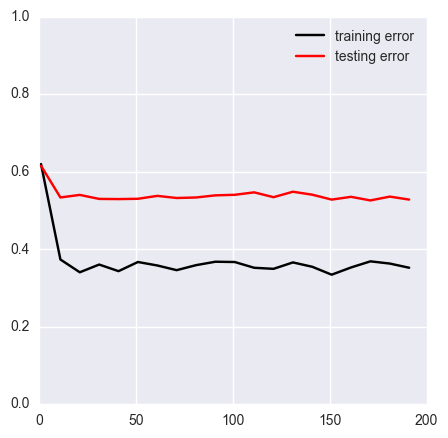

In [33]:
plt.figure(figsize=(5,5))
plt.plot(D,1-F1_rf_train,color='black',label='training error')
plt.plot(D,1-F1_rf_test,color='red',label='testing error')
plt.legend(loc='best')
plt.ylim(0,1)

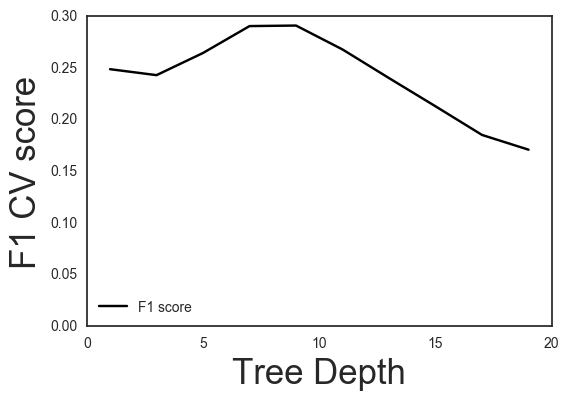

In [75]:
fig,ax1 = plt.subplots()
ax1.plot(D,F1,color='black',label='F1 score')
ax1.set_xlabel('Tree Depth',fontsize=25)
plt.ylim(0,0.3)
plt.ylabel('F1 CV score',fontsize=25)
plt.legend(loc='lower left')

In [13]:
w

array([ 10.,  10.,  10.,  50.,  50.,  50.,  50.,  50.,  10.,  10.])

In [20]:
rf = ensemble.RandomForestClassifier(n_estimators = 100,max_depth=1,max_features='sqrt',class_weight='balanced',min_samples_split=20)
rf.fit(x_train,y_train)
y_predict = rf.predict(x_test)
acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test,confusion=False,disp=True)

          Predicted NO  Predicted YES
True NO         2350.0          791.0
True YES          26.0          231.0

F1: 0.361

Accuracy on class 0: 0.75
Accuracy on class 1: 0.90



In [80]:
features = data.columns.values[:-1]
E = np.array([5,10,25,50]) #np.arange(1,50,10)
D = np.arange(1,20,2)
F1_boost,w = np.zeros(D.shape[0]),np.zeros(D.shape[0])

for i,d in enumerate(D):
    
    for e in E:
        rf = ensemble.GradientBoostingClassifier(n_estimators = e,max_depth=d,max_features='sqrt')

        kf = model_selection.KFold(n_splits=2)
        cum_F1 = 0.0

        for train_index,test_index in kf.split(x_train):
            x_train_cv = x_train[train_index,:]
            y_train_cv = y_train[train_index]
            x_test_cv = x_train[test_index,:]
            y_test_cv = y_train[test_index]

            rf.fit(x_train_cv,y_train_cv)
            y_predict = rf.predict(x_test_cv)

            acc_pos,acc_neg,F1_k = sf.score_both_and_confuse(y_predict,y_test_cv,confusion=False,disp=False)

            cum_F1 += F1_k

        F1_cv = cum_F1 / 3.0
    
        if F1_cv > F1_boost[i]:
            F1_boost[i] = F1_cv
            w[i] = e

([<matplotlib.axis.YTick at 0x11bbab860>,
 <a list of 4 Text yticklabel objects>)

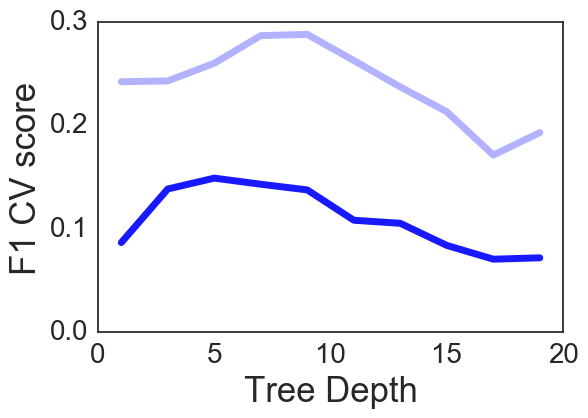

In [114]:
fig,ax1 = plt.subplots()
ax1.plot(D,F1_rf,color='blue',label='Random Forest',linewidth=5,alpha=0.3)
plt.plot(D,F1_boost,color='blue',label="Boosting",alpha=0.9,linewidth=5)
ax1.set_xlabel('Tree Depth',fontsize=25)
plt.ylim(0,0.3)
plt.ylabel('F1 CV score',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks([0,0.1,0.2,0.3],fontsize=20)

In [102]:
boost = ensemble.GradientBoostingClassifier(n_estimators=50,max_depth=5)
boost.fit(x_train,y_train)
y_predict = boost.predict(x_test)
acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test,confusion=False,disp=True)

          Predicted NO  Predicted YES
True NO         3043.0           50.0
True YES         257.0           48.0

F1: 0.238

Accuracy on class 0: 0.98
Accuracy on class 1: 0.16



In [108]:
ada= ensemble.AdaBoostClassifier(n_estimators=100)
ada.fit(x_train,y_train)
y_predict = ada.predict(x_test)
acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test,confusion=False,disp=True)

          Predicted NO  Predicted YES
True NO         3022.0           71.0
True YES         253.0           52.0

F1: 0.243

Accuracy on class 0: 0.98
Accuracy on class 1: 0.17



This is maybe doing a little better than our single models, but not by much. 

# Neural Net

In [37]:
mlp = neural_network.MLPClassifier(hidden_layer_sizes=(30,15,7))
mlp.fit(x_train,y_train)
y_predict = mlp.predict(x_test)
acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test,confusion=False,disp=True)

          Predicted NO  Predicted YES
True NO         3057.0           84.0
True YES         190.0           67.0

F1: 0.328

Accuracy on class 0: 0.97
Accuracy on class 1: 0.26



In [16]:
mlp.coefs_[0]

array([[-0.007135  , -0.04163636,  0.00335061, ...,  0.2056332 ,
        -0.2474716 ,  0.01009447],
       [-0.04297648, -0.10517854, -0.05941977, ..., -0.20498744,
        -0.0259902 ,  0.03459121],
       [-0.01125303,  0.09107229, -0.16669009, ...,  0.09378345,
        -0.19487751, -0.14958358],
       ..., 
       [ 0.05781792,  0.11676558,  0.19791104, ..., -0.08346158,
        -0.11341126,  0.05979339],
       [ 0.14964907, -0.13699291, -0.06494882, ..., -0.09940432,
        -0.22932466,  0.06416281],
       [ 0.16625971, -0.17248249, -0.04364734, ...,  0.08550826,
         0.19526544, -0.18894126]])

ValueError: x and y must be the same size

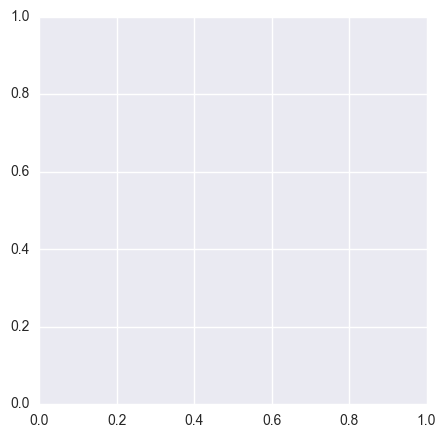

In [17]:
plt.figure(figsize=(5,5))
plt.scatter(np.arange(27),mlp.coefs_[0][:,0])